In [1]:
# packages
import numpy as np 
import matplotlib.pyplot as plt
import os
from scipy import integrate
from scipy.stats import norm
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.dates as mdates

import astropy.coordinates as coord
import astropy.units as u
from scipy import integrate, optimize

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# graphic parameters
plt.rcParams['font.size'] = 19
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['axes.linewidth']  = 1.4
plt.rcParams['figure.figsize']  = (8, 4)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 1.8
plt.rcParams['ytick.major.width'] = 1.8   
plt.rcParams['lines.markeredgewidth'] = 2

# defining a numpy seed for random
np.random.seed(0)

# creating a folder to save the plots
pltpath = 'plots/'
if not os.path.exists(pltpath):
    os.makedirs(pltpath)
dpi      = 400     # resolution of saved images
formatIm = '.pdf'  # format of saved images

# ----- some constants ----- #
G     = 6.6743e-8     # gravitational constant
kb    = 1.3807e-16    # Boltzmann constant
sigma = 5.67e-5       # Stefan-Boltzmann constant
Msun  = 1.9884e33     # sun mass
Rsun  = 6.957e10      # sun radius
m_H   = 1.6726e-24    # mass of the proton/hydrogen
m_e   = 9.1094e-28    # mass of the electron
c     = 2.9979e10     # speed of light
Na    = 6.022140e22   # avogadro number
aRad  = 7.5657e-15    # radiation constant
hPl   = 6.6261e-27    # planck constant
ech   = 4.8032e-10    # electron charge
hbar  = 1.0546e-27

In [13]:
df = pd.read_csv('data/fermi-data/4FGL_J2202.7+4216_daily_4_18_2023.csv')

dfc = pd.read_csv('data/fermi-data/4FGL_J0534.5+2201s_daily_4_18_2023.csv')

df

,Date(UTC),Julian Date,MET,TS,Photon Flux [0.1-100 GeV](photons cm-2 s-1),Photon Flux Error(photons cm-2 s-1),Photon Index,Photon Index Error,Sun Distance,Fit Tolerance,MINUIT Return Code,Analysis Log
0,Aug 06 2008,2454685,239716801,8.42,9.18e-8,4.10e-8,-2.14,-,155.19,1.000000e-08,0,bin1.log
1,Aug 09 2008,2454688,239976001,19.49,9.11e-8,3.53e-8,-2.14,-,155.67,1.000000e-08,0,bin2.log
2,Aug 12 2008,2454691,240235201,13.87,9.87e-8,3.97e-8,-2.14,-,155.73,1.000000e-08,0,bin3.log
3,Aug 15 2008,2454694,240494401,19.13,1.15e-7,4.07e-8,-2.14,-,155.38,1.000000e-08,0,bin4.log
4,Aug 18 2008,2454697,240753601,4.57,5.64e-8,3.64e-8,-2.14,-,154.64,1.000000e-08,0,bin5.log
...,...,...,...,...,...,...,...,...,...,...,...,...
1754,Apr 02 2023,2460038,702129601,454.45,1.01e-6,9.40e-8,-2.14,-,54.42,1.000000e-08,0,bin1785.log
1755,Apr 05 2023,2460041,702388801,137.42,5.03e-7,7.40e-8,-2.14,-,55.82,1.000000e-08,0,bin1786.log
1756,Apr 08 2023,2460044,702648001,75.34,3.69e-7,6.80e-8,-2.14,-,57.33,1.000000e-08,0,bin1787.log
1757,Apr 11 2023,2460047,702907201,119.77,3.92e-7,6.50e-8,-2.14,-,58.96,1.000000e-08,0,bin1788.log


In [14]:
flux1 = df['Photon Flux [0.1-100 GeV](photons cm-2 s-1)'].to_numpy()
fluxerr1 = df['Photon Flux Error(photons cm-2 s-1)'].to_numpy()
julian_days1 = df['Julian Date'].to_numpy().astype(float)


flux = []
julian_days = []
err = []
for f, j, fe in zip(flux1, julian_days1, fluxerr1):
    if '<' in f:
        pass
    else:
        flux.append(float(f))
        julian_days.append(j)
        err.append(float(fe))
        
        
flux = np.array(flux)
julian_days = np.array(julian_days).astype(float)
err = np.array(err)
# error1 = df['Photon Flux Error(photons cm-2 s-1)'].to_numpy()
# error = []
# for e in error1:
#     if e == '-':
#         error.append(0)
#     else:
#         error.append(float(e))


base_date = datetime(2000, 1, 1) # Julian day 2451545 corresponds to 2000-01-01
dates = [base_date + timedelta(days=jday - 2451545) for jday in julian_days]


In [15]:
flux1c = dfc['Photon Flux [0.1-100 GeV](photons cm-2 s-1)'].to_numpy()
julian_days1c = dfc['Julian Date'].to_numpy().astype(float)


fluxc = []
julian_daysc = []
for f, j in zip(flux1c, julian_days1c):
    if '<' in f:
        pass
    else:
        fluxc.append(float(f))
        julian_daysc.append(j)
fluxc = np.array(fluxc)
julian_daysc = np.array(julian_daysc).astype(float)


base_datec = datetime(2000, 1, 1) # Julian day 2451545 corresponds to 2000-01-01
datesc = [base_datec + timedelta(days=jday - 2451545) for jday in julian_daysc]

In [9]:
dates[0]

datetime.datetime(2008, 8, 8, 0, 0)

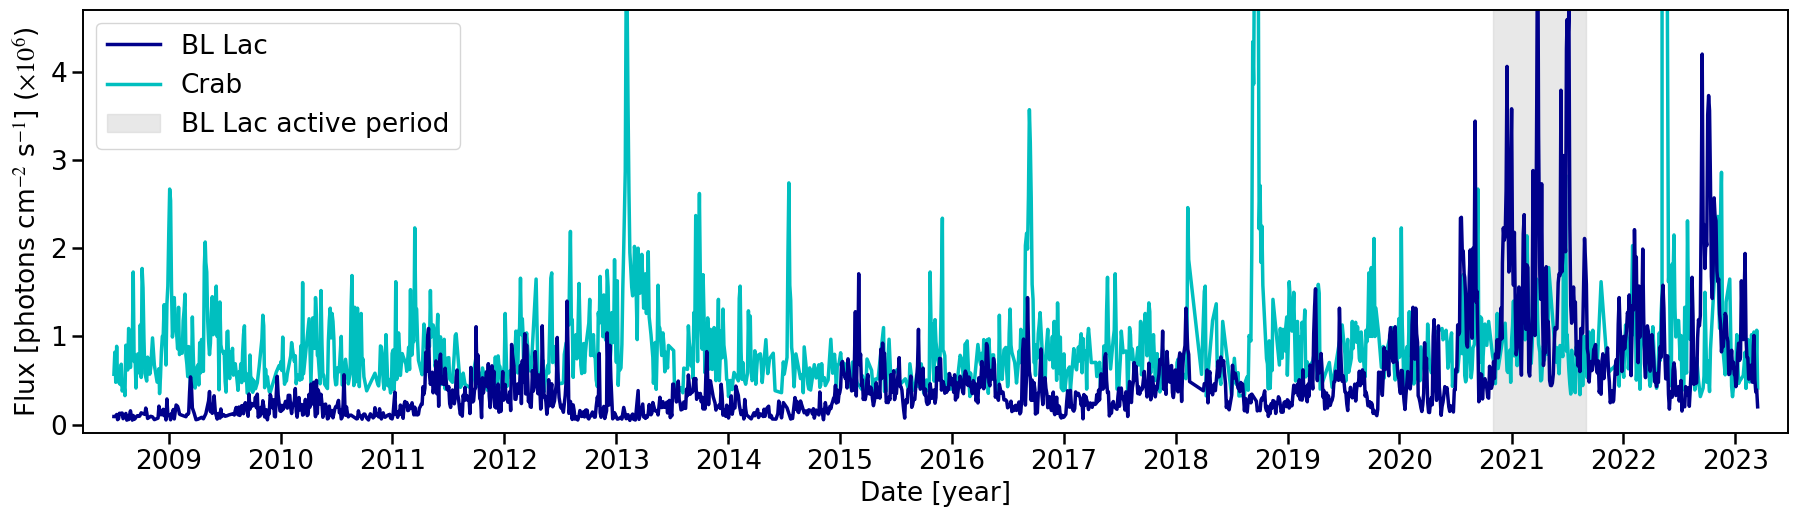

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(22, 5.5))

ax.plot(dates, flux*1e6, '-', color='darkblue', lw=2.5, zorder=1, label='BL Lac')
ax.plot(datesc, fluxc*1e6, '-', color='c', lw=2.5, zorder=0, label='Crab')
# ax.plot(dates, flux, '.')
# ax.errorbar(dates, flux, error, marker='.', ls='', capsize=0, lw=2, color='k')

# ax.axhline(2.4e-6)
ax.axvspan(dates[0]+timedelta(days=4500), dates[-1]-timedelta(days=560), zorder=-10, color='lightgray', alpha=0.5, label='BL Lac active period')

ax.set_xlim(dates[0]-timedelta(days=100), dates[-1]+timedelta(days=100))
ax.set_ylim(-0.1, 4.7)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))


ax.set_xlabel('Date [year]')
ax.set_ylabel('Flux [photons cm${}^{-2}$ s${}^{-1}$] ($\\times 10^{6}$)')
ax.legend()


# ax.set_xlim(datetime(2021, 7, 9, 0, 0), datetime(2021, 8, 13, 0, 0)) #'2021-Jul-09', '2021-Aug-13')

plt.savefig(f'{pltpath}bl-lac-lightcurve{formatIm}', bbox_inches='tight', dpi=dpi)
plt.show()

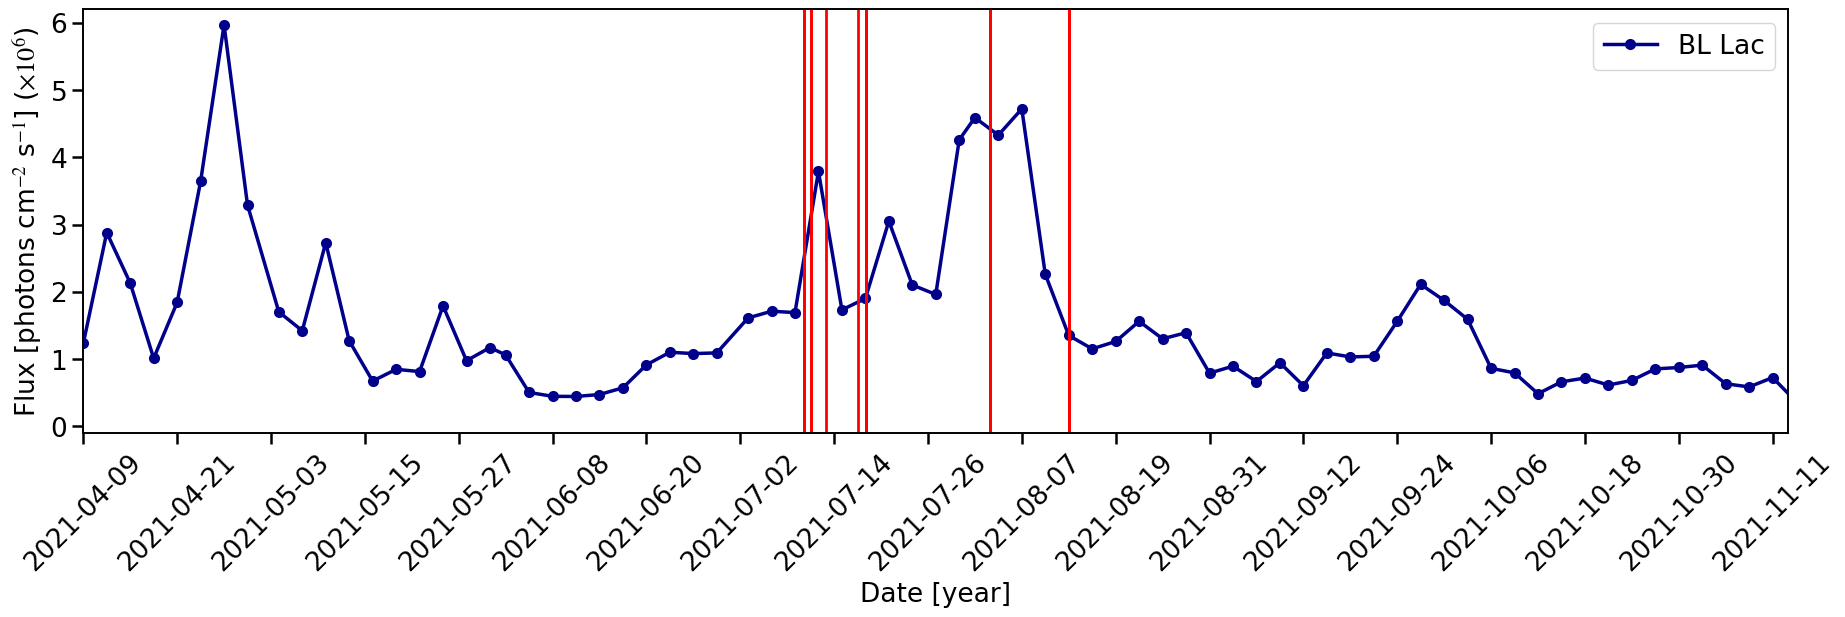

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(22, 5.5))

ax.plot(dates, flux*1e6, 'o-', color='darkblue', lw=2.5, zorder=1, label='BL Lac')
# ax.plot(dates, flux, '.')
# ax.errorbar(dates, flux, error, marker='.', ls='', capsize=0, lw=2, color='k')

# ax.axhline(2.4e-6)
ax.set_xlim(dates[0]-timedelta(days=100), dates[-1]+timedelta(days=100))
ax.set_ylim(-0.1, 6.2)

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=12))

ax.set_xlabel('Date [year]')
ax.set_ylabel('Flux [photons cm${}^{-2}$ s${}^{-1}$] ($\\times 10^{6}$)')
ax.legend()


dd = [datetime(2021, 7, 10, 2, 7, 44, 159964),
  datetime(2021, 7, 10, 2, 25, 19, 256610),
  datetime(2021, 7, 11, 0, 51, 52, 734653),
  datetime(2021, 7, 11, 1, 3, 3, 256387),
  datetime(2021, 7, 13, 0, 17, 40, 571428),
 datetime(2021, 7, 17, 2, 29, 59, 663196),
 datetime(2021, 7, 18, 2, 27, 13, 955584),
 datetime(2021, 7, 18, 2, 43, 9, 309546),
 datetime(2021, 7, 18, 2, 54, 27, 895881),
 datetime(2021, 8, 2, 22, 53, 24, 774956),
 datetime(2021, 8, 2, 23, 7, 39, 644448),
 datetime(2021, 8, 13, 0, 39, 31, 379419),
 datetime(2021, 8, 13, 0, 57, 33, 276174)]
for d in dd:
    ax.axvline(d, lw=2, color='r')

ax.tick_params(axis='x', labelrotation=45)

ax.set_xlim(datetime(2021, 4, 9, 0, 0), datetime(2021, 11, 13, 0, 0)) 

plt.show()